# Import

In [1]:
import numpy as np
import re
import math
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.metrics import auc, roc_curve, precision_recall_curve

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
from datasets import load_dataset, load_from_disk

c:\Users\alshouha\.python_venvs\transformers\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils

In [2]:
def logits_softmax(preds, T=1):
    all_logits = list()
    all_softmax = list()
    for pred in preds:
        logits = list()
        for d in pred:
            logits.append(d["score"])
        all_logits.append(np.array(logits))
        all_softmax.append(softmax_stable(logits, T))

    return all_logits, all_softmax

def softmax_stable(x, T=1):
  return (np.exp((x - np.max(x))/T) / np.exp((x - np.max(x))/T).sum())

def calc_T(x_max, x_min, epsilon=1):
    return (x_max-x_min)/(np.log(1+epsilon))

def min_T(logits, epsilon):
    Ts = list()
    for logit in logits:
        Ts.append(calc_T(np.max(logit), np.min(logit), epsilon=epsilon))
    return np.min(Ts)

def get_min_max_logit(logits_set):
    xs = list()
    for logits in logits_set:
        xs.append(np.max(logits))
    return np.max(xs)

def cutoff_youdens_j(fpr, tpr, thresholds):
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores, thresholds))
    return j_ordered[-1][1]


# Classifiers

In [3]:
models = {
    "multi" :   dict(),
    "xlm"   :   dict(),
    "xln"   :   dict()
    }

model_names = list(models.keys())

model_names

['multi', 'xlm', 'xln']

In [4]:
models_dir = "./classifiers/full_en_60"
for m in model_names:
  tokenizer_link = f"{models_dir}/{m}/{m}_tokenizer"
  model_link = f"{models_dir}/{m}/{m}_model"
  tokenizer = AutoTokenizer.from_pretrained(tokenizer_link)
  model = AutoModelForSequenceClassification.from_pretrained(model_link)
  classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, function_to_apply="none", return_all_scores=True)
  models[m]["tokenizer"] = tokenizer
  models[m]["model"] = model
  models[m]["classifier"] = classifier

c:\Users\alshouha\.python_venvs\transformers\lib\site-packages\transformers\pipelines\text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [5]:
models["multi"]["classifier"]

# Datasets

## Read all

In [6]:
main_datasets_names = ["en", "eo", "pa"]
datasets_types = ["short", "long"]
datasets_versions = ["train", "valid", "test", "train_valid"]

In [7]:
all_datasets = dict()
ds_path = "datasets/full_en_eo_pa"

for n in main_datasets_names:
    for t in datasets_types:
        for v in datasets_versions:
            ds_name = f"{n}_{v}_{t}"
            ds = load_from_disk(f"{ds_path}/{ds_name}.hf")
            all_datasets[ds_name] = ds
len(all_datasets), all_datasets

(24,
 {'en_train_short': Dataset({
      features: ['label', 'text'],
      num_rows: 11514
  }),
  'en_valid_short': Dataset({
      features: ['label', 'text'],
      num_rows: 2033
  }),
  'en_test_short': Dataset({
      features: ['label', 'text'],
      num_rows: 2974
  }),
  'en_train_valid_short': Dataset({
      features: ['label', 'text'],
      num_rows: 13547
  }),
  'en_train_long': Dataset({
      features: ['label', 'text'],
      num_rows: 11514
  }),
  'en_valid_long': Dataset({
      features: ['label', 'text'],
      num_rows: 2033
  }),
  'en_test_long': Dataset({
      features: ['label', 'text'],
      num_rows: 2974
  }),
  'en_train_valid_long': Dataset({
      features: ['label', 'text'],
      num_rows: 13547
  }),
  'eo_train_short': Dataset({
      features: ['label', 'text'],
      num_rows: 11514
  }),
  'eo_valid_short': Dataset({
      features: ['label', 'text'],
      num_rows: 2033
  }),
  'eo_test_short': Dataset({
      features: ['label', 'text'],


In [8]:
categroies_list = [
    'datetime_query',
    'iot_hue_lightchange',
    'transport_ticket',
    'takeaway_query',
    'qa_stock',
    'general_greet',
    'recommendation_events',
    'music_dislikeness',
    'iot_wemo_off',
    'cooking_recipe',
    'qa_currency',
    'transport_traffic',
    'general_quirky',
    'weather_query',
    'audio_volume_up',
    'email_addcontact',
    'takeaway_order',
    'email_querycontact',
    'iot_hue_lightup',
    'recommendation_locations',
    'play_audiobook',
    'lists_createoradd',
    'news_query',
    'alarm_query',
    'iot_wemo_on',
    'general_joke',
    'qa_definition',
    'social_query',
    'music_settings',
    'audio_volume_other',
    'calendar_remove',
    'iot_hue_lightdim',
    'calendar_query',
    'email_sendemail',
    'iot_cleaning',
    'audio_volume_down',
    'play_radio',
    'cooking_query',
    'datetime_convert',
    'qa_maths',
    'iot_hue_lightoff',
    'iot_hue_lighton',
    'transport_query',
    'music_likeness',
    'email_query',
    'play_music',
    'audio_volume_mute',
    'social_post',
    'alarm_set',
    'qa_factoid',
    'calendar_set',
    'play_game',
    'alarm_remove',
    'lists_remove',
    'transport_taxi',
    'recommendation_movies',
    'iot_coffee',
    'music_query',
    'play_podcasts',
    'lists_query']

# Predictions

## Read test

In [9]:
pred_path = "predictions/full_en_eo_pa/separate"

all_test_preds = dict()

for m in model_names:
    m_preds = dict()
    for n in main_datasets_names:
        for t in datasets_types:
            # Only test
            v = "test"
            ds_name = f"{n}_{v}_{t}"
            with open(f"{pred_path}/{m}_{ds_name}_preds.pkl", "rb") as f:
                pkl_preds = pkl.load(f)
            m_preds[f"{n}_{t}"] = pkl_preds[f"{m}_{n}_{v}_{t}"].copy()
    all_test_preds[m] = m_preds.copy()

len(all_test_preds)

3

In [10]:
all_test_preds["multi"]["en_short"]

[[{'label': 'LABEL_0', 'score': 3.6017980575561523},
  {'label': 'LABEL_1', 'score': -1.6683974266052246},
  {'label': 'LABEL_2', 'score': 1.9845737218856812},
  {'label': 'LABEL_3', 'score': -3.582380533218384},
  {'label': 'LABEL_4', 'score': -6.43688440322876},
  {'label': 'LABEL_5', 'score': -0.7700560092926025},
  {'label': 'LABEL_6', 'score': -1.317137360572815},
  {'label': 'LABEL_7', 'score': 0.15029896795749664},
  {'label': 'LABEL_8', 'score': 0.9831269979476929},
  {'label': 'LABEL_9', 'score': -3.625880002975464},
  {'label': 'LABEL_10', 'score': -2.0693020820617676},
  {'label': 'LABEL_11', 'score': -0.29731348156929016},
  {'label': 'LABEL_12', 'score': -3.797086238861084},
  {'label': 'LABEL_13', 'score': 2.7018983364105225},
  {'label': 'LABEL_14', 'score': 2.614745616912842},
  {'label': 'LABEL_15', 'score': 1.4082224369049072},
  {'label': 'LABEL_16', 'score': -2.081319570541382},
  {'label': 'LABEL_17', 'score': -1.7231860160827637},
  {'label': 'LABEL_18', 'score': 

In [11]:
all_test_preds["multi"].keys()

dict_keys(['en_short', 'en_long', 'eo_short', 'eo_long', 'pa_short', 'pa_long'])

## Read train

In [12]:
pred_path = "predictions/full_en_eo_pa/separate"

all_train_preds = dict()

# predicting is not done yet
# Only multi
# Only English (en)
for m in model_names:
    m_preds = dict()
    for n in main_datasets_names:
        for t in datasets_types:
            v = "train" # Only train
            t = "short" # Only short
            ds_name = f"{n}_{v}_{t}"
            with open(f"{pred_path}/{m}_{ds_name}_preds.pkl", "rb") as f:
                pkl_preds = pkl.load(f)
            m_preds[f"{n}_{t}"] = pkl_preds[f"{m}_{n}_{v}_{t}"].copy()
    all_train_preds[m] = m_preds.copy()

len(all_train_preds)

3

In [13]:
all_train_preds["multi"].keys(), len(all_train_preds["multi"]["en_short"])

(dict_keys(['en_short', 'eo_short', 'pa_short']), 11514)

In [14]:
# with open("./predictions/all_test_predictions.pkl", "rb") as f:
#     pkl_test_predictions = pkl.load(f)
# type(pkl_test_predictions)

In [15]:
# with open("./predictions/all_train_predictions.pkl", "rb") as f:
#     pkl_train_predictions = pkl.load(f)
# type(pkl_train_predictions)

In [16]:
# categroies_list = list()
# for p in pkl_predictions["multi"]["massive"][0]:
#     categroies_list.append(p["label"])
# categroies_list

In [17]:
# preds_dict = dict()

# for model in model_names:
#     preds_dict[model] = dict()
#     for dataset in datasets_names:
#         preds_dict[model][dataset] = dict()
#         preds = pkl_test_predictions[model][dataset].copy()
#         logits, softmax = logits_softmax(preds)
#         preds_dict[model][dataset]["logits"] = logits.copy()
#         preds_dict[model][dataset]["softmax"] = softmax.copy()
        
#         pred_labels = list()
#         correct = np.zeros((len(logits)))
#         for i in range(len(logits)):
#             pred_label = np.argmax(logits[i])
#             pred_labels.append(pred_label)
#             if (pred_label == pkl_test_datasets[dataset]["label"][i]): correct[i]=1
#         preds_dict[model][dataset]["pred_label"] = pred_labels.copy()
#         preds_dict[model][dataset]["correct"] = correct.copy()

In [18]:
# preds_dict["multi"]["en_ID"]["correct"]

In [19]:
# preds_dict["multi"]["en_ID"].keys()

In [20]:
# len(np.array(maxs)[np.where(correct==1)]), len(np.array(maxs)[np.where(correct==0)]), len(np.array(maxs))

## T = 1

In [21]:
test_preds_dict = dict()

for m in model_names:
    test_preds_dict[m] = dict()
    for n in main_datasets_names:
        for t in datasets_types:
            v = "test"
            ds_name = f"{n}_{t}"
            test_preds_dict[m][ds_name] = dict()
            preds = all_test_preds[m][f"{n}_{t}"].copy()
            logits, softmax = logits_softmax(preds)
            test_preds_dict[m][ds_name]["logits"] = logits.copy()
            test_preds_dict[m][ds_name]["softmax"] = softmax.copy()
            
            pred_labels = list()
            correct = np.zeros((len(logits)))
            for i in range(len(logits)):
                pred_label = np.argmax(logits[i])
                pred_labels.append(pred_label)
                if (pred_label == all_datasets[f"{n}_{v}_{t}"]["label"][i]): correct[i]=1
            test_preds_dict[m][ds_name]["pred_label"] = pred_labels.copy()
            test_preds_dict[m][ds_name]["correct"] = correct.copy()
len(test_preds_dict)

3

In [22]:
test_preds_dict["multi"].keys()

dict_keys(['en_short', 'en_long', 'eo_short', 'eo_long', 'pa_short', 'pa_long'])

In [23]:
datasets_names = list(test_preds_dict["multi"].keys())
datasets_names

['en_short', 'en_long', 'eo_short', 'eo_long', 'pa_short', 'pa_long']

In [24]:
# Dataset split (short and long are separate)

for model in model_names:
    print(f"========== {model} ==============")
    for dataset in datasets_names:
        # if dataset in set(["en_ID", "en_OOD", "es_ID", "pa_ID"]):
            # if starts here
            print(f"> {dataset}")
            logits = test_preds_dict[model][dataset]["logits"].copy()
            softmax = test_preds_dict[model][dataset]["softmax"].copy()
            correct = test_preds_dict[model][dataset]["correct"].copy()
            maxs, mins, sms, diffs = list(), list(), list(), list()
            for logit, sm in zip(logits, softmax):
                maxs.append(np.max(logit))
                mins.append(np.min(logit))
                sms.append(np.max(sm))
                diffs.append(np.max(logit)-np.min(logit))
            maxs, mins = np.array(maxs), np.array(mins)
            sms, diffs = np.array(sms), np.array(diffs)

            Acc = round(np.mean(correct),2)
            print(np.mean(correct))
            print(f"Acc:\t\t{Acc}")

            print("Overall: ")
            max_avg, max_std = round(np.mean(maxs),2), round(np.std(maxs),2)
            min_avg, min_std = round(np.mean(mins),2), round(np.std(mins),2)
            diff = round(max_avg-min_avg,2)
            max_diff, min_diff, avg_diff = round(np.max(diffs),2), round(np.min(diffs),2), round(np.mean(diffs),2)
            sms_avg, sms_std = round(np.mean(sms),2), round(np.std(sms),2)
            sms_max, sms_min = round(np.max(sms),2), round(np.min(sms),2)
            print(f"logits:\t\tmax: {max_avg}\tmin: {min_avg}\tdiff: {diff}")
            print(f"logits:\t\tstd: {max_std}\tstd: {min_std}\t")
            print(f"softmax:\tmax: {sms_max}\tmin: {sms_min}")
            print(f"softmax:\tavg: {sms_avg}\tstd: {sms_std}")
            print(f"diff:\t\tmax: {max_diff}\tmin: {min_diff}\tavg: {avg_diff}")

            print("Correct: ")
            c = 1
            max_avg, max_std = round(np.mean(maxs[np.where(correct==c)]),2), round(np.std(maxs[np.where(correct==c)]),2)
            min_avg, min_std = round(np.mean(mins[np.where(correct==c)]),2), round(np.std(mins[np.where(correct==c)]),2)
            diff = round(max_avg-min_avg,2)
            max_diff, min_diff, avg_diff = round(np.max(diffs[np.where(correct==c)]),2), round(np.min(diffs[np.where(correct==c)]),2), round(np.mean(diffs[np.where(correct==c)]),2)
            sms_avg, sms_std = round(np.mean(sms[np.where(correct==c)]),2), round(np.std(sms[np.where(correct==c)]),2)
            sms_max, sms_min = round(np.max(sms[np.where(correct==c)]),2), round(np.min(sms[np.where(correct==c)]),2)
            print(f"logits:\t\tmax: {max_avg}\tmin: {min_avg}\tdiff: {diff}")
            print(f"logits:\t\tstd: {max_std}\tstd: {min_std}\t")
            print(f"softmax:\tmax: {sms_max}\tmin: {sms_min}")
            print(f"softmax:\tavg: {sms_avg}\tstd: {sms_std}")
            print(f"diff:\t\tmax: {max_diff}\tmin: {min_diff}\tavg: {avg_diff}")

            print("Wrong: ")
            c = 0
            max_avg, max_std = round(np.mean(maxs[np.where(correct==c)]),2), round(np.std(maxs[np.where(correct==c)]),2)
            min_avg, min_std = round(np.mean(mins[np.where(correct==c)]),2), round(np.std(mins[np.where(correct==c)]),2)
            diff = round(max_avg-min_avg,2)
            max_diff, min_diff, avg_diff = round(np.max(diffs[np.where(correct==c)]),2), round(np.min(diffs[np.where(correct==c)]),2), round(np.mean(diffs[np.where(correct==c)]),2)
            sms_avg, sms_std = round(np.mean(sms[np.where(correct==c)]),2), round(np.std(sms[np.where(correct==c)]),2)
            sms_max, sms_min = round(np.max(sms[np.where(correct==c)]),2), round(np.min(sms[np.where(correct==c)]),2)
            print(f"logits:\t\tmax: {max_avg}\tmin: {min_avg}\tdiff: {diff}")
            print(f"logits:\t\tstd: {max_std}\tstd: {min_std}\t")
            print(f"softmax:\tmax: {sms_max}\tmin: {sms_min}")
            print(f"softmax:\tavg: {sms_avg}\tstd: {sms_std}")
            print(f"diff:\t\tmax: {max_diff}\tmin: {min_diff}\tavg: {avg_diff}")

========== multi ==============
> en_short
0.8456624075319435
Acc:		0.85
Overall: 
logits:		max: 9.47	min: -5.59	diff: 15.06
logits:		std: 1.17	std: 0.86	
softmax:	max: 1.0	min: 0.15
softmax:	avg: 0.91	std: 0.16
diff:		max: 17.78	min: 7.36	avg: 15.07
Correct: 
logits:		max: 9.68	min: -5.59	diff: 15.27
logits:		std: 0.99	std: 0.86	
softmax:	max: 1.0	min: 0.25
softmax:	avg: 0.94	std: 0.12
diff:		max: 17.78	min: 8.75	avg: 15.27
Wrong: 
logits:		max: 8.35	min: -5.63	diff: 13.98
logits:		std: 1.39	std: 0.84	
softmax:	max: 1.0	min: 0.15
softmax:	avg: 0.75	std: 0.23
diff:		max: 17.63	min: 7.36	avg: 13.97
> en_long
0.7868190988567586
Acc:		0.79
Overall: 
logits:		max: 8.94	min: -5.57	diff: 14.51
logits:		std: 1.41	std: 0.89	
softmax:	max: 1.0	min: 0.14
softmax:	avg: 0.84	std: 0.2
diff:		max: 17.78	min: 6.61	avg: 14.51
Correct: 
logits:		max: 9.32	min: -5.58	diff: 14.9
logits:		std: 1.15	std: 0.9	
softmax:	max: 1.0	min: 0.24
softmax:	avg: 0.9	std: 0.15
diff:		max: 17.78	min: 8.27	avg: 14.9
Wron

In [25]:
# Dataset merged (short and long are together)

for model in model_names:
    print(f"========== {model} ==============")
    for dataset in main_datasets_names:
        # if dataset in set(["en_ID", "en_OOD", "es_ID", "pa_ID"]):
            # if starts here
            print(f"> {dataset}")
            logits, softmax, correct = list(), list(), np.array(list())
            for t in datasets_types:
                logits.extend(test_preds_dict[model][f"{dataset}_{t}"]["logits"])
                softmax.extend(test_preds_dict[model][f"{dataset}_{t}"]["softmax"])
                correct = np.append(correct, test_preds_dict[model][f"{dataset}_{t}"]["correct"])
            # logits = test_preds_dict[model][dataset]["logits"].copy()
            # softmax = test_preds_dict[model][dataset]["softmax"].copy()
            # correct = test_preds_dict[model][dataset]["correct"].copy()
            maxs, mins, sms, diffs = list(), list(), list(), list()
            for logit, sm in zip(logits, softmax):
                maxs.append(np.max(logit))
                mins.append(np.min(logit))
                sms.append(np.max(sm))
                diffs.append(np.max(logit)-np.min(logit))
            maxs, mins = np.array(maxs), np.array(mins)
            sms, diffs = np.array(sms), np.array(diffs)

            Acc = round(np.mean(correct),2)
            print(f"Acc:\t\t{Acc}")

            print("Overall: ")
            max_avg, max_std = round(np.mean(maxs),2), round(np.std(maxs),2)
            min_avg, min_std = round(np.mean(mins),2), round(np.std(mins),2)
            diff = round(max_avg-min_avg,2)
            max_diff, min_diff, avg_diff = round(np.max(diffs),2), round(np.min(diffs),2), round(np.mean(diffs),2)
            sms_avg, sms_std = round(np.mean(sms),2), round(np.std(sms),2)
            sms_max, sms_min = round(np.max(sms),2), round(np.min(sms),2)
            print(f"logits:\t\tmax: {max_avg}\tmin: {min_avg}\tdiff: {diff}")
            print(f"logits:\t\tstd: {max_std}\tstd: {min_std}\t")
            print(f"softmax:\tmax: {sms_max}\tmin: {sms_min}")
            print(f"softmax:\tavg: {sms_avg}\tstd: {sms_std}")
            print(f"diff:\t\tmax: {max_diff}\tmin: {min_diff}\tavg: {avg_diff}")

            print("Correct: ")
            c = 1
            max_avg, max_std = round(np.mean(maxs[np.where(correct==c)]),2), round(np.std(maxs[np.where(correct==c)]),2)
            min_avg, min_std = round(np.mean(mins[np.where(correct==c)]),2), round(np.std(mins[np.where(correct==c)]),2)
            diff = round(max_avg-min_avg,2)
            max_diff, min_diff, avg_diff = round(np.max(diffs[np.where(correct==c)]),2), round(np.min(diffs[np.where(correct==c)]),2), round(np.mean(diffs[np.where(correct==c)]),2)
            sms_avg, sms_std = round(np.mean(sms[np.where(correct==c)]),2), round(np.std(sms[np.where(correct==c)]),2)
            sms_max, sms_min = round(np.max(sms[np.where(correct==c)]),2), round(np.min(sms[np.where(correct==c)]),2)
            print(f"logits:\t\tmax: {max_avg}\tmin: {min_avg}\tdiff: {diff}")
            print(f"logits:\t\tstd: {max_std}\tstd: {min_std}\t")
            print(f"softmax:\tmax: {sms_max}\tmin: {sms_min}")
            print(f"softmax:\tavg: {sms_avg}\tstd: {sms_std}")
            print(f"diff:\t\tmax: {max_diff}\tmin: {min_diff}\tavg: {avg_diff}")

            print("Wrong: ")
            c = 0
            max_avg, max_std = round(np.mean(maxs[np.where(correct==c)]),2), round(np.std(maxs[np.where(correct==c)]),2)
            min_avg, min_std = round(np.mean(mins[np.where(correct==c)]),2), round(np.std(mins[np.where(correct==c)]),2)
            diff = round(max_avg-min_avg,2)
            max_diff, min_diff, avg_diff = round(np.max(diffs[np.where(correct==c)]),2), round(np.min(diffs[np.where(correct==c)]),2), round(np.mean(diffs[np.where(correct==c)]),2)
            sms_avg, sms_std = round(np.mean(sms[np.where(correct==c)]),2), round(np.std(sms[np.where(correct==c)]),2)
            sms_max, sms_min = round(np.max(sms[np.where(correct==c)]),2), round(np.min(sms[np.where(correct==c)]),2)
            print(f"logits:\t\tmax: {max_avg}\tmin: {min_avg}\tdiff: {diff}")
            print(f"logits:\t\tstd: {max_std}\tstd: {min_std}\t")
            print(f"softmax:\tmax: {sms_max}\tmin: {sms_min}")
            print(f"softmax:\tavg: {sms_avg}\tstd: {sms_std}")
            print(f"diff:\t\tmax: {max_diff}\tmin: {min_diff}\tavg: {avg_diff}")

========== multi ==============
> en
Acc:		0.82
Overall: 
logits:		max: 9.21	min: -5.58	diff: 14.79
logits:		std: 1.32	std: 0.88	
softmax:	max: 1.0	min: 0.14
softmax:	avg: 0.88	std: 0.19
diff:		max: 17.78	min: 6.61	avg: 14.79
Correct: 
logits:		max: 9.51	min: -5.58	diff: 15.09
logits:		std: 1.08	std: 0.88	
softmax:	max: 1.0	min: 0.24
softmax:	avg: 0.92	std: 0.14
diff:		max: 17.78	min: 8.27	avg: 15.09
Wrong: 
logits:		max: 7.88	min: -5.58	diff: 13.46
logits:		std: 1.45	std: 0.86	
softmax:	max: 1.0	min: 0.14
softmax:	avg: 0.68	std: 0.24
diff:		max: 17.63	min: 6.61	avg: 13.46
> eo
Acc:		0.38
Overall: 
logits:		max: 7.85	min: -5.49	diff: 13.34
logits:		std: 1.74	std: 0.92	
softmax:	max: 1.0	min: 0.1
softmax:	avg: 0.7	std: 0.26
diff:		max: 17.8	min: 6.17	avg: 13.34
Correct: 
logits:		max: 8.94	min: -5.52	diff: 14.46
logits:		std: 1.42	std: 0.89	
softmax:	max: 1.0	min: 0.14
softmax:	avg: 0.85	std: 0.2
diff:		max: 17.61	min: 7.61	avg: 14.45
Wrong: 
logits:		max: 7.17	min: -5.48	diff: 12.65
lo

In [26]:
# Dataset merged (short and long are together)
T = 1

model_col, dataset_col, T_col, softmax_col, correct_col = list(), list(), list(), list(), list()

for model in model_names:
    for dataset in main_datasets_names:
        softmax, correct = list(), list()
        for t in datasets_types:
            # logits.extend(test_preds_dict[model][f"{dataset}_{t}"]["logits"])
            softmax.extend(test_preds_dict[model][f"{dataset}_{t}"]["softmax"])
            correct.extend(test_preds_dict[model][f"{dataset}_{t}"]["correct"].astype(int).tolist())
        
        sms = list()
        for sm in softmax:
            sms.append(np.max(sm))
        # sms = np.array(sms)

        model_col.extend([model for _ in range(len(sms))])
        dataset_col.extend([dataset for _ in range(len(sms))])
        T_col.extend([T for _ in range(len(sms))])
        softmax_col.extend(sms)
        correct_col.extend(correct)

print(len(model_col), len(dataset_col), len(T_col), len(softmax_col), len(correct_col))

53532 53532 53532 53532 53532


In [27]:
columns = ["model", "dataset", "T", "softmax", "correct"]

test_df = pd.DataFrame(list(zip(model_col, dataset_col, T_col, softmax_col, correct_col)),
                       columns=columns)

test_df.head()

model dataset  T   softmax  correct
0  multi      en  1  0.981744        1
1  multi      en  1  0.933719        1
2  multi      en  1  0.411817        1
3  multi      en  1  0.280858        0
4  multi      en  1  0.912091        1

## T = min_T

In [28]:
# T(logits, epsilon)
epsilon = 10

T_dict = dict()

for m in model_names:
    for d in main_datasets_names[:1]: # T only based on the training data ("en")
        logits = list()
        all_scores = all_train_preds[m][f"{d}_short"]
        for score in all_scores:
            logit = list()
            for item in score:
                logit.append(item["score"])
            logits.append(logit)
        T_dict[f"{m}_{d}"] = min_T(logits, epsilon)
T_dict

{'multi_en': 3.1351218058984,
 'xlm_en': 1.9922525025978355,
 'xln_en': 2.786103024421497}

In [29]:
logits = list()
all_scores = all_train_preds[m][f"{d}_short"]
for score in all_scores:
    logit = list()
    for item in score:
        logit.append(item["score"])
    logits.append(logit)
len(logit), len(all_train_preds[m][f"{d}_short"]), len(logits)

(60, 11514, 11514)

In [30]:
len(all_train_preds[m][f"{d}_short"][0])

60

In [31]:
test_preds_T_dict = dict()

for m in model_names:
    test_preds_T_dict[m] = dict()
    for n in main_datasets_names:
        for t in datasets_types:
            v = "test"
            ds_name = f"{n}_{t}"
            test_preds_T_dict[m][ds_name] = dict()
            preds = all_test_preds[m][f"{n}_{t}"].copy()
            logits, softmax = logits_softmax(preds, T=T_dict[f"{m}_en"])
            test_preds_T_dict[m][ds_name]["logits"] = logits.copy()
            test_preds_T_dict[m][ds_name]["softmax"] = softmax.copy()
            
            pred_labels = list()
            correct = np.zeros((len(logits)))
            for i in range(len(logits)):
                pred_label = np.argmax(logits[i])
                pred_labels.append(pred_label)
                if (pred_label == all_datasets[f"{n}_{v}_{t}"]["label"][i]): correct[i]=1
            test_preds_T_dict[m][ds_name]["pred_label"] = pred_labels.copy()
            test_preds_T_dict[m][ds_name]["correct"] = correct.copy()
len(test_preds_T_dict)

3

In [32]:
len(test_preds_T_dict["multi"]["en_short"]["pred_label"])

2974

In [33]:
datasets_names = list(test_preds_T_dict["multi"].keys())
datasets_names

['en_short', 'en_long', 'eo_short', 'eo_long', 'pa_short', 'pa_long']

In [34]:
for model in model_names:
    print(f"========== {model} ==============")
    for dataset in datasets_names:
        # if dataset in set(["en_ID", "en_OOD", "es_ID", "pa_ID"]):
            # if starts here
            print(f"> {dataset}")
            logits = test_preds_T_dict[model][dataset]["logits"].copy()
            softmax = test_preds_T_dict[model][dataset]["softmax"].copy()
            correct = test_preds_T_dict[model][dataset]["correct"].copy()
            maxs, mins, sms, diffs = list(), list(), list(), list()
            for logit, sm in zip(logits, softmax):
                maxs.append(np.max(logit))
                mins.append(np.min(logit))
                sms.append(np.max(sm))
                diffs.append(np.max(logit)-np.min(logit))
            maxs, mins = np.array(maxs), np.array(mins)
            sms, diffs = np.array(sms), np.array(diffs)

            Acc = round(np.mean(correct),2)
            print(f"Acc:\t\t{Acc}")

            print("Overall: ")
            max_avg, max_std = round(np.mean(maxs),2), round(np.std(maxs),2)
            min_avg, min_std = round(np.mean(mins),2), round(np.std(mins),2)
            diff = round(max_avg-min_avg,2)
            max_diff, min_diff, avg_diff = round(np.max(diffs),2), round(np.min(diffs),2), round(np.mean(diffs),2)
            sms_avg, sms_std = round(np.mean(sms),2), round(np.std(sms),2)
            sms_max, sms_min = round(np.max(sms),2), round(np.min(sms),2)
            print(f"logits:\t\tmax: {max_avg}\tmin: {min_avg}\tdiff: {diff}")
            print(f"logits:\t\tstd: {max_std}\tstd: {min_std}\t")
            print(f"softmax:\tmax: {sms_max}\tmin: {sms_min}")
            print(f"softmax:\tavg: {sms_avg}\tstd: {sms_std}")
            print(f"diff:\t\tmax: {max_diff}\tmin: {min_diff}\tavg: {avg_diff}")

            print("Correct: ")
            c = 1
            max_avg, max_std = round(np.mean(maxs[np.where(correct==c)]),2), round(np.std(maxs[np.where(correct==c)]),2)
            min_avg, min_std = round(np.mean(mins[np.where(correct==c)]),2), round(np.std(mins[np.where(correct==c)]),2)
            diff = round(max_avg-min_avg,2)
            max_diff, min_diff, avg_diff = round(np.max(diffs[np.where(correct==c)]),2), round(np.min(diffs[np.where(correct==c)]),2), round(np.mean(diffs[np.where(correct==c)]),2)
            sms_avg, sms_std = round(np.mean(sms[np.where(correct==c)]),2), round(np.std(sms[np.where(correct==c)]),2)
            sms_max, sms_min = round(np.max(sms[np.where(correct==c)]),2), round(np.min(sms[np.where(correct==c)]),2)
            print(f"logits:\t\tmax: {max_avg}\tmin: {min_avg}\tdiff: {diff}")
            print(f"logits:\t\tstd: {max_std}\tstd: {min_std}\t")
            print(f"softmax:\tmax: {sms_max}\tmin: {sms_min}")
            print(f"softmax:\tavg: {sms_avg}\tstd: {sms_std}")
            print(f"diff:\t\tmax: {max_diff}\tmin: {min_diff}\tavg: {avg_diff}")

            print("Wrong: ")
            c = 0
            max_avg, max_std = round(np.mean(maxs[np.where(correct==c)]),2), round(np.std(maxs[np.where(correct==c)]),2)
            min_avg, min_std = round(np.mean(mins[np.where(correct==c)]),2), round(np.std(mins[np.where(correct==c)]),2)
            diff = round(max_avg-min_avg,2)
            max_diff, min_diff, avg_diff = round(np.max(diffs[np.where(correct==c)]),2), round(np.min(diffs[np.where(correct==c)]),2), round(np.mean(diffs[np.where(correct==c)]),2)
            sms_avg, sms_std = round(np.mean(sms[np.where(correct==c)]),2), round(np.std(sms[np.where(correct==c)]),2)
            sms_max, sms_min = round(np.max(sms[np.where(correct==c)]),2), round(np.min(sms[np.where(correct==c)]),2)
            print(f"logits:\t\tmax: {max_avg}\tmin: {min_avg}\tdiff: {diff}")
            print(f"logits:\t\tstd: {max_std}\tstd: {min_std}\t")
            print(f"softmax:\tmax: {sms_max}\tmin: {sms_min}")
            print(f"softmax:\tavg: {sms_avg}\tstd: {sms_std}")
            print(f"diff:\t\tmax: {max_diff}\tmin: {min_diff}\tavg: {avg_diff}")

========== multi ==============
> en_short
Acc:		0.85
Overall: 
logits:		max: 9.47	min: -5.59	diff: 15.06
logits:		std: 1.17	std: 0.86	
softmax:	max: 0.33	min: 0.04
softmax:	avg: 0.23	std: 0.07
diff:		max: 17.78	min: 7.36	avg: 15.07
Correct: 
logits:		max: 9.68	min: -5.59	diff: 15.27
logits:		std: 0.99	std: 0.86	
softmax:	max: 0.33	min: 0.06
softmax:	avg: 0.25	std: 0.06
diff:		max: 17.78	min: 8.75	avg: 15.27
Wrong: 
logits:		max: 8.35	min: -5.63	diff: 13.98
logits:		std: 1.39	std: 0.84	
softmax:	max: 0.33	min: 0.04
softmax:	avg: 0.18	std: 0.07
diff:		max: 17.63	min: 7.36	avg: 13.97
> en_long
Acc:		0.79
Overall: 
logits:		max: 8.94	min: -5.57	diff: 14.51
logits:		std: 1.41	std: 0.89	
softmax:	max: 0.33	min: 0.05
softmax:	avg: 0.21	std: 0.07
diff:		max: 17.78	min: 6.61	avg: 14.51
Correct: 
logits:		max: 9.32	min: -5.58	diff: 14.9
logits:		std: 1.15	std: 0.9	
softmax:	max: 0.33	min: 0.06
softmax:	avg: 0.22	std: 0.07
diff:		max: 17.78	min: 8.27	avg: 14.9
Wrong: 
logits:		max: 7.54	min: -5.

In [35]:
for model in model_names:
    print(f"========== {model} ==============")
    for dataset in main_datasets_names:
        # if dataset in set(["en_ID", "en_OOD", "es_ID", "pa_ID"]):
            # if starts here
            print(f"> {dataset}")
            logits, softmax, correct = list(), list(), np.array(list())
            for t in datasets_types:
                logits.extend(test_preds_T_dict[model][f"{dataset}_{t}"]["logits"])
                softmax.extend(test_preds_T_dict[model][f"{dataset}_{t}"]["softmax"])
                correct = np.append(correct, test_preds_T_dict[model][f"{dataset}_{t}"]["correct"])
            maxs, mins, sms, diffs = list(), list(), list(), list()
            for logit, sm in zip(logits, softmax):
                maxs.append(np.max(logit))
                mins.append(np.min(logit))
                sms.append(np.max(sm))
                diffs.append(np.max(logit)-np.min(logit))
            maxs, mins = np.array(maxs), np.array(mins)
            sms, diffs = np.array(sms), np.array(diffs)

            Acc = round(np.mean(correct),2)
            print(f"Acc:\t\t{Acc}")

            print("Overall: ")
            max_avg, max_std = round(np.mean(maxs),2), round(np.std(maxs),2)
            min_avg, min_std = round(np.mean(mins),2), round(np.std(mins),2)
            diff = round(max_avg-min_avg,2)
            max_diff, min_diff, avg_diff = round(np.max(diffs),2), round(np.min(diffs),2), round(np.mean(diffs),2)
            sms_avg, sms_std = round(np.mean(sms),2), round(np.std(sms),2)
            sms_max, sms_min = round(np.max(sms),2), round(np.min(sms),2)
            print(f"logits:\t\tmax: {max_avg}\tmin: {min_avg}\tdiff: {diff}")
            print(f"logits:\t\tstd: {max_std}\tstd: {min_std}\t")
            print(f"softmax:\tmax: {sms_max}\tmin: {sms_min}")
            print(f"softmax:\tavg: {sms_avg}\tstd: {sms_std}")
            print(f"diff:\t\tmax: {max_diff}\tmin: {min_diff}\tavg: {avg_diff}")

            print("Correct: ")
            c = 1
            max_avg, max_std = round(np.mean(maxs[np.where(correct==c)]),2), round(np.std(maxs[np.where(correct==c)]),2)
            min_avg, min_std = round(np.mean(mins[np.where(correct==c)]),2), round(np.std(mins[np.where(correct==c)]),2)
            diff = round(max_avg-min_avg,2)
            max_diff, min_diff, avg_diff = round(np.max(diffs[np.where(correct==c)]),2), round(np.min(diffs[np.where(correct==c)]),2), round(np.mean(diffs[np.where(correct==c)]),2)
            sms_avg, sms_std = round(np.mean(sms[np.where(correct==c)]),2), round(np.std(sms[np.where(correct==c)]),2)
            sms_max, sms_min = round(np.max(sms[np.where(correct==c)]),2), round(np.min(sms[np.where(correct==c)]),2)
            print(f"logits:\t\tmax: {max_avg}\tmin: {min_avg}\tdiff: {diff}")
            print(f"logits:\t\tstd: {max_std}\tstd: {min_std}\t")
            print(f"softmax:\tmax: {sms_max}\tmin: {sms_min}")
            print(f"softmax:\tavg: {sms_avg}\tstd: {sms_std}")
            print(f"diff:\t\tmax: {max_diff}\tmin: {min_diff}\tavg: {avg_diff}")

            print("Wrong: ")
            c = 0
            max_avg, max_std = round(np.mean(maxs[np.where(correct==c)]),2), round(np.std(maxs[np.where(correct==c)]),2)
            min_avg, min_std = round(np.mean(mins[np.where(correct==c)]),2), round(np.std(mins[np.where(correct==c)]),2)
            diff = round(max_avg-min_avg,2)
            max_diff, min_diff, avg_diff = round(np.max(diffs[np.where(correct==c)]),2), round(np.min(diffs[np.where(correct==c)]),2), round(np.mean(diffs[np.where(correct==c)]),2)
            sms_avg, sms_std = round(np.mean(sms[np.where(correct==c)]),2), round(np.std(sms[np.where(correct==c)]),2)
            sms_max, sms_min = round(np.max(sms[np.where(correct==c)]),2), round(np.min(sms[np.where(correct==c)]),2)
            print(f"logits:\t\tmax: {max_avg}\tmin: {min_avg}\tdiff: {diff}")
            print(f"logits:\t\tstd: {max_std}\tstd: {min_std}\t")
            print(f"softmax:\tmax: {sms_max}\tmin: {sms_min}")
            print(f"softmax:\tavg: {sms_avg}\tstd: {sms_std}")
            print(f"diff:\t\tmax: {max_diff}\tmin: {min_diff}\tavg: {avg_diff}")

========== multi ==============
> en
Acc:		0.82
Overall: 
logits:		max: 9.21	min: -5.58	diff: 14.79
logits:		std: 1.32	std: 0.88	
softmax:	max: 0.33	min: 0.04
softmax:	avg: 0.22	std: 0.07
diff:		max: 17.78	min: 6.61	avg: 14.79
Correct: 
logits:		max: 9.51	min: -5.58	diff: 15.09
logits:		std: 1.08	std: 0.88	
softmax:	max: 0.33	min: 0.06
softmax:	avg: 0.23	std: 0.07
diff:		max: 17.78	min: 8.27	avg: 15.09
Wrong: 
logits:		max: 7.88	min: -5.58	diff: 13.46
logits:		std: 1.45	std: 0.86	
softmax:	max: 0.33	min: 0.04
softmax:	avg: 0.15	std: 0.07
diff:		max: 17.63	min: 6.61	avg: 13.46
> eo
Acc:		0.38
Overall: 
logits:		max: 7.85	min: -5.49	diff: 13.34
logits:		std: 1.74	std: 0.92	
softmax:	max: 0.34	min: 0.04
softmax:	avg: 0.16	std: 0.08
diff:		max: 17.8	min: 6.17	avg: 13.34
Correct: 
logits:		max: 8.94	min: -5.52	diff: 14.46
logits:		std: 1.42	std: 0.89	
softmax:	max: 0.33	min: 0.05
softmax:	avg: 0.21	std: 0.07
diff:		max: 17.61	min: 7.61	avg: 14.45
Wrong: 
logits:		max: 7.17	min: -5.48	diff: 

In [36]:
# Dataset merged (short and long are together)

model_col, dataset_col, T_col, softmax_col, correct_col = list(), list(), list(), list(), list()

for model in model_names:
    T = T_dict[f"{m}_en"]
    for dataset in main_datasets_names:
        softmax, correct = list(), list()
        for t in datasets_types:
            softmax.extend(test_preds_T_dict[model][f"{dataset}_{t}"]["softmax"])
            correct.extend(test_preds_T_dict[model][f"{dataset}_{t}"]["correct"].astype(int).tolist())
        
        sms = list()
        for sm in softmax:
            sms.append(np.max(sm))
        # sms = np.array(sms)

        model_col.extend([model for _ in range(len(sms))])
        dataset_col.extend([dataset for _ in range(len(sms))])
        T_col.extend([T for _ in range(len(sms))])
        softmax_col.extend(sms)
        correct_col.extend(correct)

print(len(model_col), len(dataset_col), len(T_col), len(softmax_col), len(correct_col))

53532 53532 53532 53532 53532


In [37]:
columns = ["model", "dataset", "T", "softmax", "correct"]

test_T_df = pd.DataFrame(list(zip(model_col, dataset_col, T_col, softmax_col, correct_col)),
                       columns=columns)

test_T_df.head()

model dataset         T   softmax  correct
0  multi      en  2.786103  0.243217        1
1  multi      en  2.786103  0.168415        1
2  multi      en  2.786103  0.080794        1
3  multi      en  2.786103  0.074231        0
4  multi      en  2.786103  0.180026        1

## df plots

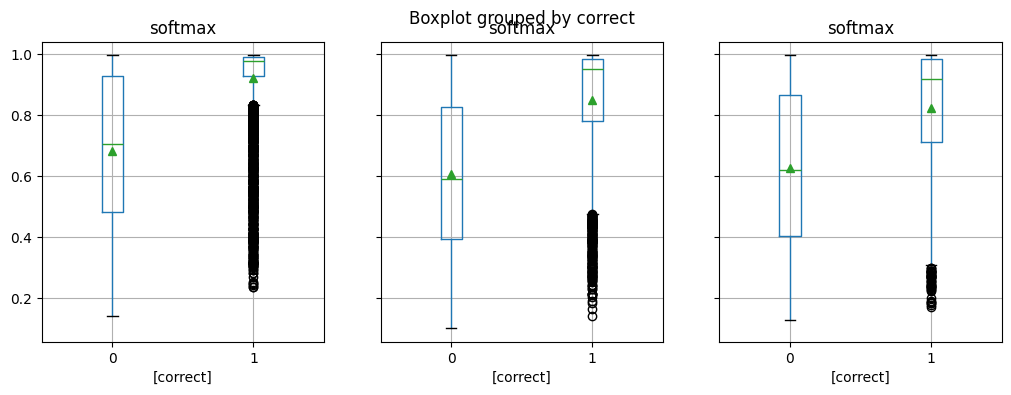

In [38]:
model = model_names[0]

selected_df = test_df.copy()

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

for i in range(3):
    P_data = selected_df.loc[(selected_df["model"]==model) & (selected_df["dataset"]==main_datasets_names[i])][["softmax", "correct"]]
    P_data.boxplot(by="correct", showmeans=True, ax=axs[i])

plt.show()

In [42]:
selected_df = test_df.copy()

for model in model_names:
    print(f">>>>>>>> {model} <<<<<<<<")
    for i in range(3):
        ds = main_datasets_names[i]
        sm = selected_df.loc[(selected_df["model"]==model) & (selected_df["dataset"]==ds)][["softmax"]].values *100
        c = selected_df.loc[(selected_df["model"]==model) & (selected_df["dataset"]==ds)][["correct"]].values
        data = [sm[np.where(c==1)], sm[np.where(c==0)]]

        c_q75, c_q25  = np.percentile(data[0], [75, 25])
        w_q75, w_q25  = np.percentile(data[1], [75, 25])
        Q_IR = max(0, w_q75-c_q25) / (c_q75-w_q25)
        print(f"{model} - {ds} : {Q_IR}")
        
        plt.rcParams.update({'font.size': 22, 'font.family': 'times new roman'})
        # plt.style.use('classic')

        plt.figure(figsize=(8, 8))
        plt.ylim(0, 105)
        plt.yticks(range(0, 105, 10))
        plt.ylabel("(%)", rotation=0, labelpad=20)
        plt.boxplot(data, labels=["correct", "wrong"], showmeans=True)
        plt.grid()
        plt.savefig(f"figs/{model}_{ds}.png", bbox_inches='tight')
        plt.close()

>>>>>>>> multi <<<<<<<<
multi - en : 0.005465928596623341
multi - eo : 0.07741653842304135
multi - pa : 0.26045221817979564
>>>>>>>> xlm <<<<<<<<
xlm - en : 0.0
xlm - eo : 0.029361956042170165
xlm - pa : 0.03302094532262996
>>>>>>>> xln <<<<<<<<
xln - en : 0.006752786294280464
xln - eo : 0.19365469350769632
xln - pa : 0.4660850768968307


In [141]:
# selected_df = test_df.copy()
# plt.rcParams.update({'font.size': 22, 'font.family': 'times new roman'})

# for ds in main_datasets_names:
#     fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18, 6))
#     # fig.ylabel("(%)", rotation=0, labelpad=20)
#     for i in range(3):
#         # ds = main_datasets_names[i]
#         model = model_names[i]
#         sm = selected_df.loc[(selected_df["model"]==model) & (selected_df["dataset"]==ds)][["softmax"]].values *100
#         c = selected_df.loc[(selected_df["model"]==model) & (selected_df["dataset"]==ds)][["correct"]].values
#         data = [sm[np.where(c==1)], sm[np.where(c==0)]]

#         ax[i].set_ylim(0, 105)
#         ax[i].set_yticks(range(0, 105, 10))
#         ax[i].boxplot(data, labels=["correct", "wrong"], showmeans=True)
#         ax[i].grid()
    
#     fig.text(0.085,0.5, "(%)", ha="center", va="center", rotation=0)
#     plt.savefig(f"figs/{ds}.png", bbox_inches='tight')
#     plt.close()

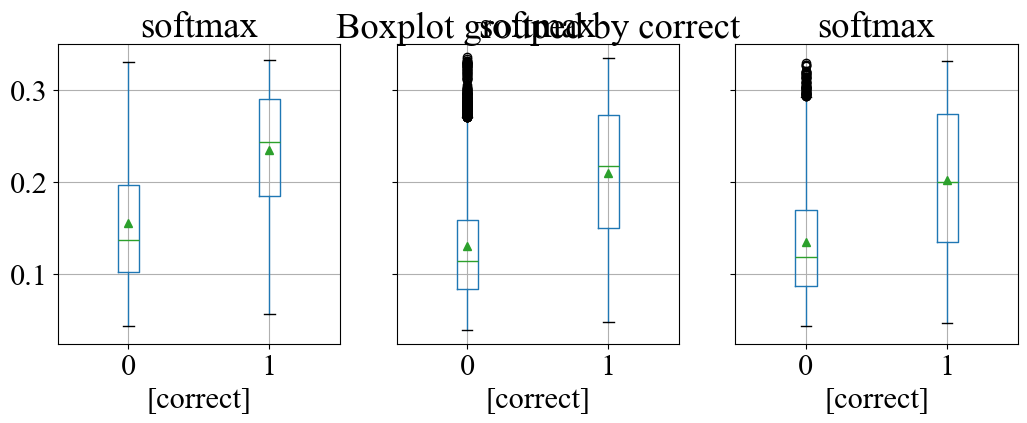

In [43]:
model = model_names[0]

selected_df = test_T_df.copy()

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

for i in range(3):
    P_data = selected_df.loc[(selected_df["model"]==model) & (selected_df["dataset"]==main_datasets_names[i])][["softmax", "correct"]]
    P_data.boxplot(by="correct", showmeans=True, ax=axs[i])

plt.style.use('seaborn-v0_8-white')
plt.show()
# tikzplotlib.save("mytikz.tex")

In [45]:
selected_df = test_T_df.copy()

for model in model_names:
    print(f">>>>>>>> {model} <<<<<<<<")
    for i in range(3):
        ds = main_datasets_names[i]
        sm = selected_df.loc[(selected_df["model"]==model) & (selected_df["dataset"]==ds)][["softmax"]].values *100
        c = selected_df.loc[(selected_df["model"]==model) & (selected_df["dataset"]==ds)][["correct"]].values
        data = [sm[np.where(c==1)], sm[np.where(c==0)]]

        c_q75, c_q25  = np.percentile(data[0], [75, 25])
        w_q75, w_q25  = np.percentile(data[1], [75, 25])
        Q_IR = max(0, w_q75-c_q25) / (c_q75-w_q25)
        print(f"{model} - {ds} : {Q_IR}")
        
        plt.rcParams.update({'font.size': 22, 'font.family': 'times new roman'})
        # plt.style.use('classic')

        plt.figure(figsize=(8, 8))
        plt.ylim(0, 105)
        plt.yticks(range(0, 105, 10))
        plt.ylabel("(%)", rotation=0, labelpad=20)
        plt.boxplot(data, labels=["correct", "wrong"], showmeans=True)
        plt.grid()
        plt.savefig(f"figs/{model}_{ds}_T.png", bbox_inches='tight')
        plt.close()

>>>>>>>> multi <<<<<<<<
multi - en : 0.066304233246324
multi - eo : 0.04570488513850911
multi - pa : 0.1821047340513915
>>>>>>>> xlm <<<<<<<<
xlm - en : 0.0
xlm - eo : 0.10679552260203891
xlm - pa : 0.1055869949872502
>>>>>>>> xln <<<<<<<<
xln - en : 0.023485488046823155
xln - eo : 0.5294975310763862
xln - pa : 0.408139550530421


In [142]:
selected_df = test_T_df.copy()
plt.rcParams.update({'font.size': 22, 'font.family': 'times new roman'})

for ds in main_datasets_names:
    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18, 6))
    # fig.ylabel("(%)", rotation=0, labelpad=20)
    for i in range(3):
        # ds = main_datasets_names[i]
        model = model_names[i]
        sm = selected_df.loc[(selected_df["model"]==model) & (selected_df["dataset"]==ds)][["softmax"]].values *100
        c = selected_df.loc[(selected_df["model"]==model) & (selected_df["dataset"]==ds)][["correct"]].values
        data = [sm[np.where(c==1)], sm[np.where(c==0)]]

        ax[i].set_ylim(0, 105)
        ax[i].set_yticks(range(0, 105, 10))
        ax[i].boxplot(data, labels=["correct", "wrong"], showmeans=True)
        ax[i].grid()
    
    fig.text(0.085,0.5, "(%)", ha="center", va="center", rotation=0)
    plt.savefig(f"figs/{ds}_T.png", bbox_inches='tight')
    plt.close()

## Optimal threshold

In [53]:
optimal_thr = 0.2

In [65]:
selected_df = test_df.copy()

opt_correct_col = list()

for index, row in selected_df.iterrows():
    c=1 if (row["softmax"]>optimal_thr and row["correct"]==1) else 0
    opt_correct_col.append(c)
selected_df["opt_correct"] = opt_correct_col.copy()

for m_idx in range(3):
    model = model_names[m_idx]
    print(f">>>> {model} <<<<")
    for d_idx in range(3):
        ds = main_datasets_names[d_idx]
        mean = selected_df.loc[(selected_df["model"]==model) & (selected_df["dataset"]==ds)]["opt_correct"].mean()
        print(f"{ds} : {mean}")

>>>> multi <<<<
en : 0.8162407531943511
eo : 0.382817753866846
pa : 0.3429724277067922
>>>> xlm <<<<
en : 0.8643241425689308
eo : 0.48100201748486887
pa : 0.4784801613987895
>>>> xln <<<<
en : 0.8280094149293881
eo : 0.15887693342299933
pa : 0.05211835911230666


In [66]:
selected_df = test_T_df.copy()

opt_correct_col = list()

for index, row in selected_df.iterrows():
    c=1 if (row["softmax"]>optimal_thr and row["correct"]==1) else 0
    opt_correct_col.append(c)
selected_df["opt_correct"] = opt_correct_col.copy()


for m_idx in range(3):
    model = model_names[m_idx]
    print(f">>>> {model} <<<<")
    for d_idx in range(3):
        ds = main_datasets_names[d_idx]
        mean = selected_df.loc[(selected_df["model"]==model) & (selected_df["dataset"]==ds)]["opt_correct"].mean()
        print(f"{ds} : {mean}")

>>>> multi <<<<
en : 0.5734700739744452
eo : 0.21435776731674513
pa : 0.17215870880968392
>>>> xlm <<<<
en : 0.863315400134499
eo : 0.47074646940147946
pa : 0.4704102219233356
>>>> xln <<<<
en : 0.800941492938803
eo : 0.12592468056489575
pa : 0.005211835911230666


In [41]:
# m = model_names[0]
# n = "en"
# test_preds = deepcopy(test_preds_T_dict)

# train_label = deepcopy(all_datasets[f"{n}_train_short"]["label"])

# pred_label = test_preds[m][f"{n}_short"]["pred_label"]
# pred_label.extend(test_preds[m][f"{n}_long"]["pred_label"])
# print(len(pred_label))

# label_binarizer = LabelBinarizer().fit(train_label)
# y_onehot_test = label_binarizer.transform(pred_label)

# pred_score = test_preds[m][f"{n}_short"]["softmax"]
# pred_score.extend(test_preds[m][f"{n}_long"]["softmax"])
# pred_score = np.array(pred_score)

# y_onehot_test.shape, pred_score.shape

In [42]:
# len(test_preds_T_dict[m][f"{n}_short"]["pred_label"])

In [43]:
# test_preds_T_dict[m][f"{n}_short"]["softmax"]

In [44]:
# n = "en"
# m = model_names[0]

# gt_labels = np.array(deepcopy(all_datasets[f"{n}_test_short"]["label"]))
# pred_labels = np.array(deepcopy(test_preds_T_dict[m][f"{n}_short"]["pred_label"]))
# pred_softmax = np.array(deepcopy(test_preds_T_dict[m][f"{n}_short"]["softmax"]))

# print(gt_labels.shape, pred_labels.shape)

# i = 43

# gt_labels_is_i = np.where(gt_labels==i)[0]
# pred_labels_is_i = np.where(pred_labels==i)[0]
# correct_is_i = set(gt_labels_is_i) & set(pred_labels_is_i)

# # pred_labels[np.where(train_labels==0)]
# print("Acc: ", len(correct_is_i)/len(gt_labels_is_i))

# y_true = np.zeros((gt_labels.shape))
# y_true[gt_labels_is_i] = 1
# y_score = np.array([np.max(s) for s in pred_softmax])

In [45]:
# fpr, tpr, thrs = roc_curve(y_true, y_score)

# print(auc(fpr, tpr))

# optimal_thr = cutoff_youdens_j(fpr, tpr, thrs)
# optimal_thr

In [97]:
# n_classes = 60

# for i in range(n_classes):

#     gt_labels = np.array(deepcopy(all_datasets[f"{n}_test_short"]["label"]))
#     y_true = np.zeros((gt_labels.shape))
#     gt_labels_is_i = np.where(gt_labels==i)[0]
#     y_true[gt_labels_is_i] = 1

#     pred_softmax = np.array(deepcopy(test_preds_T_dict[m][f"{n}_short"]["softmax"]))
#     y_score = np.array([np.max(s) for s in pred_softmax])

#     # Computing best threshold for i-th class
#     precision, recall, thresholds = precision_recall_curve(y_true, y_score) #, pos_label=i)

#     # compute f-1
#     f1 = 2 * precision * recall / (precision + recall)

#     # pick up the best threshold's index
#     best_idx = np.argmax(f1)
#     print(f'For class {i} the best possible threshold is {thresholds[best_idx]:.3f} wich leads to f1={f1[best_idx]:.3f}')

# others

In [20]:
train_preds_dict = dict()

for model in model_names:
    train_preds_dict[model] = dict()
    for dataset in list(pkl_train_predictions[model].keys()):
        train_preds_dict[model][dataset] = dict()
        preds = pkl_train_predictions[model][dataset].copy()
        logits, softmax = logits_softmax(preds)
        train_preds_dict[model][dataset]["logits"] = logits.copy()
        train_preds_dict[model][dataset]["softmax"] = softmax.copy()
        
        pred_labels = list()
        correct = np.zeros((len(logits)))
        for i in range(len(logits)):
            pred_label = np.argmax(logits[i])
            pred_labels.append(pred_label)
            if (pred_label == pkl_train_datasets[dataset]["label"][i]): correct[i]=1
        train_preds_dict[model][dataset]["pred_label"] = pred_labels.copy()
        train_preds_dict[model][dataset]["correct"] = correct.copy()

In [73]:
train_datasets_names = list(pkl_train_predictions["multi"].keys())
Ts = dict()

for model in model_names:
    Ts_dict = dict()
    for train_dataset in train_datasets_names:
        logits = train_preds_dict[model][f"{train_dataset}"]["logits"].copy()
        diffs = list()
        for logit, sm in zip(logits, softmax):
            diffs.append(np.max(logit)-np.min(logit))

        min_diff = np.min(diffs)
        epsilon = 0.01 #len(logits)
        T = min_diff/(np.log(1+epsilon))
        Ts_dict[train_dataset] = T
    Ts[model] = Ts_dict.copy()

In [74]:
Ts

{'multi': {'en_ID_full': 771.5751007258493,
  'en_ID_train': 771.5751007258493,
  'en_ID_valid': 754.2740830173568},
 'xlm': {'en_ID_full': 726.4877888135983,
  'en_ID_train': 726.4877888135983,
  'en_ID_valid': 708.3811587506179},
 'xln': {'en_ID_full': 743.4029886013257,
  'en_ID_train': 743.4029886013257,
  'en_ID_valid': 674.61911953586}}

In [76]:
for model in model_names:
    print(f"========== {model} ==============")
    sm_ref = None
    sm_thr = None
    for dataset in datasets_names:
        if dataset in set(["en_ID", "en_OOD", "es_ID", "pa_ID"]):
            print(f"> {dataset}")
            logits = preds_dict[model][dataset]["logits"].copy()
            softmax = preds_dict[model][dataset]["softmax"].copy()
            maxs, mins, sms, diffs = list(), list(), list(), list()
            for logit, sm in zip(logits, softmax):
                maxs.append(np.max(logit))
                mins.append(np.min(logit))
                sms.append(np.max(sm))
                diffs.append(np.max(logit)-np.min(logit))
            max_avg, max_std = round(np.mean(maxs),2), round(np.std(maxs),2)
            min_avg, min_std = round(np.mean(mins),2), round(np.std(mins),2)
            diff = round(max_avg-min_avg,2)
            max_diff, min_diff, avg_diff = round(np.max(diffs),2), round(np.min(diffs),2), round(np.mean(diffs),2)
            sms_avg, sms_std = round(np.mean(sms),2), round(np.std(sms),2)
            sms_max, sms_min = round(np.max(sms),2), round(np.min(sms),2)
            
            if not (sm_ref and sm_thr): # set based on en_ID
                sm_ref_min, sm_ref_max = sms_avg-sms_std, sms_avg+sms_std
                sm_thr = sms_avg

            thr = sm_thr
            T = Ts[model]["en_ID_full"]
            if dataset=="en_ID":
                correct = np.zeros((len(sms)))
                for i in range(len(sms)):
                    sm = sms[i]
                    if (sm>=sm_ref_min) and (sm<=sm_ref_max): sm=np.max(softmax_stable(softmax[i], T))
                    if sm>=thr: correct[i]=1
                acc = round(np.mean(correct),2)
                print(f"Acc:\t\t{thr}: {acc}")
            else:                
                correct = np.zeros((len(sms)))
                for i in range(len(sms)):
                    sm = sms[i]
                    if (sm>=sm_ref_min) and (sm<=sm_ref_max): sm=np.max(softmax_stable(softmax[i], T))
                    if sm<thr: correct[i]=1
                acc = round(np.mean(correct),2)
                print(f"Acc:\t\t{thr}: {acc}")
                
            print(f"logits:\t\tmax: {max_avg}\tmin: {min_avg}\tdiff: {diff}")
            print(f"logits:\t\tstd: {max_std}\tstd: {min_std}\t")
            print(f"softmax:\tmax: {sms_max}\tmin: {sms_min}")
            print(f"softmax:\tavg: {sms_avg}\tstd: {sms_std}")
            print(f"diff:\t\tmax: {max_diff}\tmin: {min_diff}\tavg: {avg_diff}")

========== multi ==============
> en_ID
Acc:		0.91: 0.0
logits:		max: 9.32	min: -5.72	diff: 15.04
logits:		std: 1.27	std: 1.26	
softmax:	max: 1.0	min: 0.16
softmax:	avg: 0.91	std: 0.15
diff:		max: 18.52	min: 8.37	avg: 15.04
> en_OOD
Acc:		0.79: 1.0
logits:		max: 8.07	min: -5.57	diff: 13.64
logits:		std: 1.36	std: 0.86	
softmax:	max: 1.0	min: 0.18
softmax:	avg: 0.79	std: 0.21
diff:		max: 18.47	min: 9.35	avg: 13.64
> es_ID
Acc:		0.79: 1.0
logits:		max: 8.37	min: -5.6	diff: 13.97
logits:		std: 1.52	std: 1.02	
softmax:	max: 1.0	min: 0.15
softmax:	avg: 0.79	std: 0.23
diff:		max: 18.39	min: 6.1	avg: 13.97
> pa_ID
Acc:		0.77: 1.0
logits:		max: 8.17	min: -5.38	diff: 13.55
logits:		std: 1.56	std: 0.84	
softmax:	max: 1.0	min: 0.11
softmax:	avg: 0.77	std: 0.23
diff:		max: 18.35	min: 6.94	avg: 13.55
========== xlm ==============
> en_ID
Acc:		0.98: 0.0
logits:		max: 12.14	min: -3.09	diff: 15.23
logits:		std: 1.35	std: 0.69	
softmax:	max: 1.0	min: 0.19
softmax:	avg: 0.98	std: 0.08
diff:		max: 17.99

In [28]:
train_datasets_names = list(pkl_train_predictions["multi"].keys())
min_max_xs = dict()

for model in model_names:
    min_max_xs_dict = dict()
    for train_dataset in train_datasets_names:
        logits = train_preds_dict[model][f"{train_dataset}"]["logits"].copy()
        min_max_xs_dict[train_dataset] = get_min_max_logit(logits)
    min_max_xs[model] = min_max_xs_dict.copy()

In [29]:
min_max_xs

{'multi': {'en_ID_full': 11.030062675476074,
  'en_ID_train': 11.030062675476074,
  'en_ID_valid': 10.991902351379395},
 'xlm': {'en_ID_full': 13.732680320739746,
  'en_ID_train': 13.732680320739746,
  'en_ID_valid': 13.688568115234375},
 'xln': {'en_ID_full': 12.499258995056152,
  'en_ID_train': 12.499258995056152,
  'en_ID_valid': 12.492020606994629}}

In [ ]:
for model in model_names:
    train_preds_dict[model] = dict()
    for dataset in list(pkl_train_predictions[model].keys()):

In [27]:
datasets_names

['en_ID',
 'en_ID_short',
 'en_ID_long',
 'en_OOD',
 'en_OOD_short',
 'en_OOD_long',
 'es_ID',
 'es_ID_short',
 'es_ID_long',
 'es_OOD',
 'es_OOD_short',
 'es_OOD_long',
 'pa_ID',
 'pa_ID_short',
 'pa_ID_long',
 'pa_OOD',
 'pa_OOD_short',
 'pa_OOD_long']

In [36]:
main_dataset_softmax = dict()

main_ID_datasets_names = ["en_ID", "es_ID", "pa_ID"]

for model in model_names:
    main_dataset_softmax[model] = dict()
    for main_dataset in main_ID_datasets_names:
        softmaxs, re_softmaxs, all_correct = list(), list(), list()
        main_dataset_softmax[model][f"{main_dataset}"] = dict()
  
        # short = preds_dict[model][f"{main_dataset}_short"]["correct"]
        # long = preds_dict[model][f"{main_dataset}_long"]["correct"]
        # all_correct = np.concatenate((short, long))
        main_dataset_softmax[model][main_dataset]["correct"] = np.array(preds_dict[model][f"{main_dataset}"]["correct"].copy())

        short = preds_dict[model][f"{main_dataset}_short"]["logits"]
        long = preds_dict[model][f"{main_dataset}_long"]["logits"]
        all_ = preds_dict[model][f"{main_dataset}"]["logits"]
        T = 1
        for item in all_:
            softmaxs.append(softmax_stable(item, T))
        main_dataset_softmax[model][main_dataset]["softmax"] = np.array(softmaxs.copy())

        T = 1
        for item in short:
            re_softmaxs.append(softmax_stable(item, T))
        T = Ts["en_ID_full"]
        for item in long:
            re_softmaxs.append(softmax_stable(item, T))
        main_dataset_softmax[model][main_dataset]["re_softmax"] = np.array(re_softmaxs.copy())

In [37]:
# main_dataset_softmax[model][main_dataset]["softmax"][-1] == main_dataset_softmax[model][main_dataset]["re_softmax"][-1]

In [38]:
# np.max(main_dataset_softmax[model][main_dataset]["softmax"][0])

In [39]:
# np.max(main_dataset_softmax[model][main_dataset]["re_softmax"][0])

In [48]:
for model in model_names:
    print(f"\n========== {model} ==============")
    for main_dataset in main_ID_datasets_names:
        print(f">>>>>>>>> {main_dataset}")
        Acc = round(np.mean(main_dataset_softmax[model][main_dataset]["correct"]), 2)
        mid_idx = int(len(main_dataset_softmax[model][main_dataset]["correct"])/2)
        short_acc = round(np.mean(main_dataset_softmax[model][main_dataset]["correct"][:mid_idx]), 2)
        long_acc = round(np.mean(main_dataset_softmax[model][main_dataset]["correct"][mid_idx:]), 2)
        print(f"Acc: {Acc}\t\t\t\t\t\tshort: {short_acc}\tlong: {long_acc}")

        softmax = main_dataset_softmax[model][main_dataset]["softmax"].copy()
        sms = np.array([np.max(sm) for sm in softmax])
        correct_avg_sm = round(np.mean(sms[np.where(correct==1)]), 2)
        wrong_avg_sm = round(np.mean(sms[np.where(correct==0)]), 2)
        short_avg_sm = round(np.mean(sms[:int(len(sms)/2)]), 2)
        long_avg_sm = round(np.mean(sms[int(len(sms)/2):]), 2)
        
        correct_std_sm = round(np.std(sms[np.where(correct==1)]), 2)
        wrong_std_sm = round(np.std(sms[np.where(correct==0)]), 2)
        short_std_sm = round(np.std(sms[:int(len(sms)/2)]), 2)
        long_std_sm = round(np.std(sms[int(len(sms)/2):]), 2)
        print(f"softmax (mean)\t\tcorrect: {correct_avg_sm}\twrong: {wrong_avg_sm}\tshort: {short_avg_sm}\tlong: {long_avg_sm}")
        print(f"softmax (std)\t\tcorrect: {correct_std_sm}\twrong: {wrong_std_sm}\tshort: {short_std_sm}\tlong: {long_std_sm}")
        
        softmax = main_dataset_softmax[model][main_dataset]["re_softmax"].copy()
        sms = np.array([np.max(sm) for sm in softmax])
        correct_avg_sm = round(np.mean(sms[np.where(correct==1)]), 2)
        wrong_avg_sm = round(np.mean(sms[np.where(correct==0)]), 2)
        short_avg_sm = round(np.mean(sms[:int(len(sms)/2)]), 2)
        long_avg_sm = round(np.mean(sms[int(len(sms)/2):]), 2)
        
        correct_std_sm = round(np.std(sms[np.where(correct==1)]), 2)
        wrong_std_sm = round(np.std(sms[np.where(correct==0)]), 2)
        short_std_sm = round(np.std(sms[:int(len(sms)/2)]), 2)
        long_std_sm = round(np.std(sms[int(len(sms)/2):]), 2)
        print(f"re_softmax (mean)\tcorrect: {correct_avg_sm}\twrong: {wrong_avg_sm}\tshort: {short_avg_sm}\tlong: {long_avg_sm}")
        print(f"re_softmax (std)\tcorrect: {correct_std_sm}\twrong: {wrong_std_sm}\tshort: {short_std_sm}\tlong: {long_std_sm}")
        


========== multi ==============
>>>>>>>>> en_ID
Acc: 0.85						short: 0.83	long: 0.86
softmax (mean)		correct: 0.9	wrong: 0.92	short: 0.89	long: 0.93
softmax (std)		correct: 0.17	wrong: 0.15	short: 0.18	long: 0.12
re_softmax (mean)	correct: 0.9	wrong: 0.91	short: 0.91	long: 0.04
re_softmax (std)	correct: 0.17	wrong: 0.15	short: 0.16	long: 0.01
>>>>>>>>> es_ID
Acc: 0.45						short: 0.44	long: 0.46
softmax (mean)		correct: 0.79	wrong: 0.78	short: 0.78	long: 0.8
softmax (std)		correct: 0.23	wrong: 0.24	short: 0.24	long: 0.22
re_softmax (mean)	correct: 0.79	wrong: 0.78	short: 0.79	long: 0.04
re_softmax (std)	correct: 0.23	wrong: 0.23	short: 0.23	long: 0.01
>>>>>>>>> pa_ID
Acc: 0.37						short: 0.35	long: 0.39
softmax (mean)		correct: 0.76	wrong: 0.75	short: 0.76	long: 0.77
softmax (std)		correct: 0.24	wrong: 0.25	short: 0.24	long: 0.22
re_softmax (mean)	correct: 0.76	wrong: 0.76	short: 0.77	long: 0.04
re_softmax (std)	correct: 0.24	wrong: 0.23	short: 0.23	long: 0.01

========== xlm ======

In [20]:
len(sms), int(len(sms)/2)

(5922, 2961)

In [21]:
i = int(len(sms)/2)
len(sms[:i]), len(sms[i:])

(2961, 2961)

In [22]:
len(main_dataset_softmax["multi"]["massive"]["softmax"][np.where(correct==1)])

1561

In [23]:
type(main_dataset_softmax[model][main_dataset]["softmax"])

numpy.ndarray

In [24]:
12, 49

(12, 49)

In [25]:
categroies_list[12], categroies_list[32]

('general_quirky', 'calendar_query')

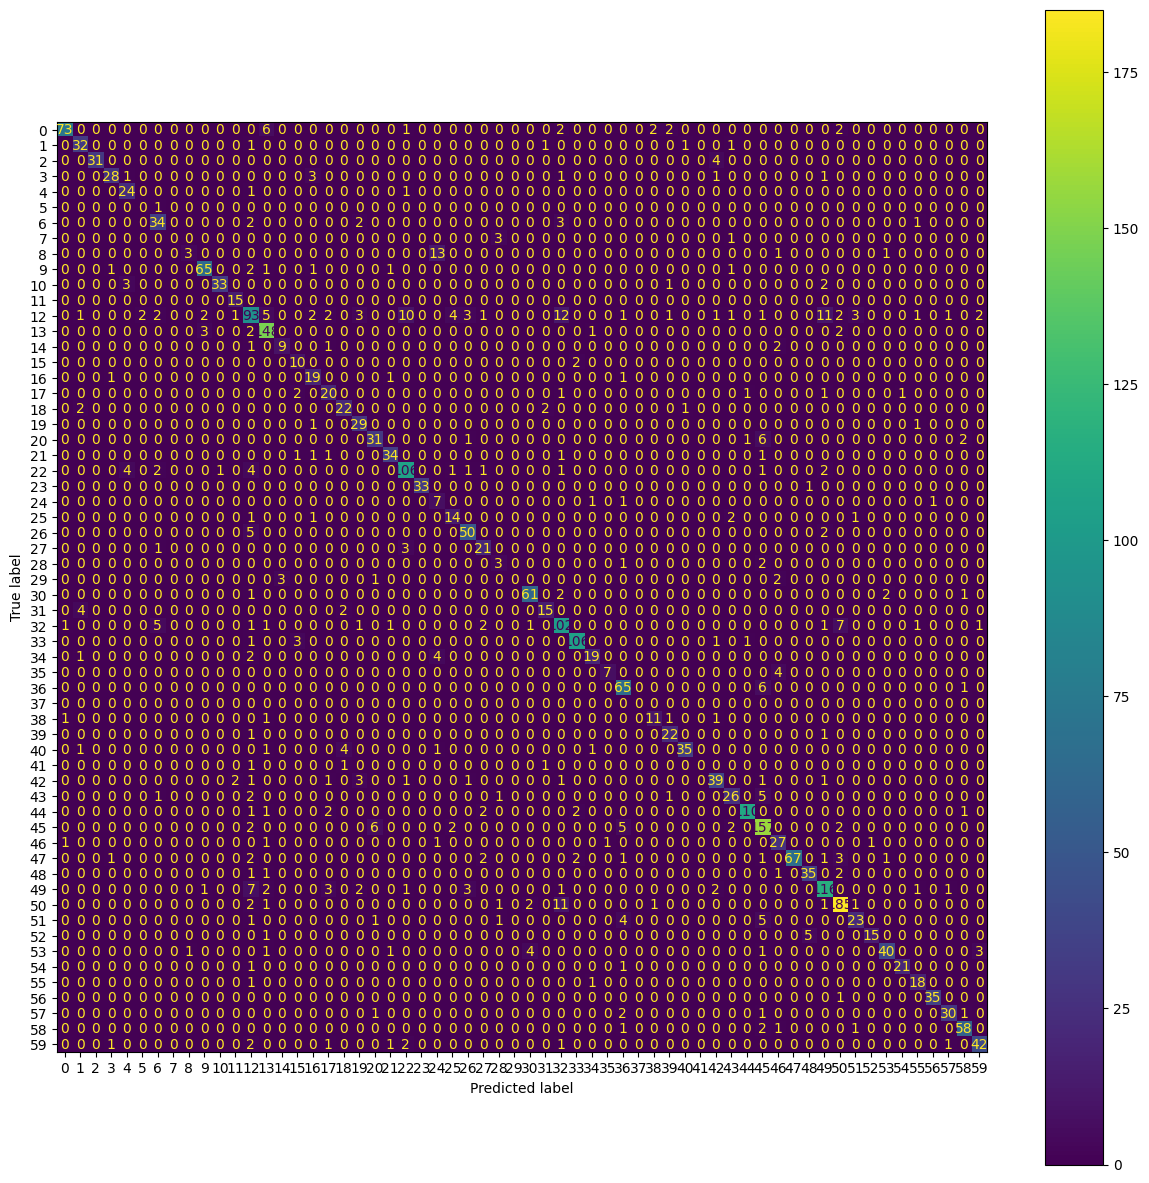

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = "multi"
dataset = "massive"

predictions = preds_dict[model][dataset]["pred_label"]
gt_labels = pkl_datasets[dataset]["label"]
labels = [i for i in range(len(categroies_list))]
cm = confusion_matrix(gt_labels, predictions, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)

fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)
plt.show()